# <center> Projet 7 : Implémentez un modèle de scoring

## Introduction


Notre mission consiste à développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

**Objectifs**

- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit


Ce notebook traite de l'analyse exploratoire des jeux de données :

- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

mis à notre disposition à partir d'un kernel kaggle.

Le **Kernel Kaggle** utilisé pour l'analyse exploratoire est disponible :
- [Kernel Kaggle : home-credit-default-risk-extensive-eda](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

# 1. Importation des modules et données

Commençons par charger les bibliothèques et modules essentiels.

In [1]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import phik
# Plotly
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Warnings
warnings.filterwarnings('ignore')

In [2]:
#Affichage des lignes et colonnes
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

# 2. Fonctions

Toutes les fonctions ont été prises du :
- [Kernel Kaggle : home-credit-default-risk-extensive-eda](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

Ce kernel est disponible aussi sur github à l'adresse :
- [Kernel Kaggle: home-credit-default-risk-extensive-eda](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

In [3]:
def load_all_tables(directory_path='', verbose=True):
    '''
    Function to load all the tables required
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not

    '''
    if verbose:
        print("Chargement des jeux de donnees...")
        print("--------------------------------------------------------------------")
        start = datetime.now()

    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Fichier application_train.csv chargé -> dataframe : application_train")

    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Fichier application_test.csv chargé -> dataframe : application_test")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Fichier bureau.csv chargé -> dataframe : bureau")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Fichier bureau_balance.csv chargé -> dataframe : bureau_balance")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Fichier credit_card_balance.csv chargé -> dataframe : cc_balance")

    installments_payments = pd.read_csv(
        directory_path + 'installments_payments.csv')
    if verbose:
        print(
            "Fichier installments_payments.csv chargé -> dataframe : installments_payments")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance")

    HomeCredit_columns_description = pd.read_csv(
        directory_path +
        'HomeCredit_columns_description.csv',
        encoding='cp1252')
    del HomeCredit_columns_description['Unnamed: 0']
    if verbose:
        print("Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description")

    previous_application = pd.read_csv(
        directory_path + 'previous_application.csv')
    if verbose:
        print("Fichier previous_application.csv chargé -> dataframe : previous_application")

    if verbose:
        print("--------------------------------------------------------------------")
        print(
            f'Chargement des 9 jeux de donnees terminée en {datetime.now() - start} secondes')

    return application_train, application_test, bureau, bureau_balance, \
        cc_balance, installments_payments, POS_CASH_balance, previous_application, \
        HomeCredit_columns_description



# AFFICHER LES STATISTIQUES SIMPLES ligne, varaible,duplicate, head
def afficher_stats_basic(dataframe, titre='application_train'):
    print('-' * 79)
    # Taille : nombre de lignes/colonnes
    nRow, nVar = dataframe.shape
    print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')
    print('-' * 79)
    duplicate = \
        dataframe.shape[0] - dataframe.duplicated().shape[0]
    print(f'Numbre de valeurs dupliquées dans {titre} : {duplicate}')
    print('-' * 79)
    print('Contenu des 3 premières lignes :')
    display(dataframe.head(3))

    
    
# CREATION DATAFRAME DES VALEURS MANQUANTES
def nan_df_create(data):
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    Inputs:
        data:
            DataFrame

    Returns:
        DataFrame of NaN percentages
    '''
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column': nan_percentages.index,
                       'percent': nan_percentages.values})

    # sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by='percent', ascending=False, inplace=True)

    return df



# REPRESENTATION BARPLOT DES VALEURS MANQUANTES PAR VARIABLE
def plot_nan_percent(df_nan, title_name, tight_layout=True, figsize=(20, 8),
                     grid=False, rotation=90, fontsize=16):
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values

    Inputs:
        df_nan:
            DataFrame of NaN percentages
        title_name:
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
    '''
    sns.set(style='white', font_scale=1.2)
    # checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(
            f"Nombre de variables avec valeurs manquantes : {df_nan[df_nan['percent'] != 0].shape[0]}")

        # plotting the Bar-Plot for NaN percentages (only for columns with
        # Non-Zero percentage of NaN values)
        plt.figure(figsize=figsize, tight_layout=tight_layout)
        sns.barplot(x='column', y='percent',
                    data=df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation=rotation)
        plt.xlabel('Nom de variable', fontsize=fontsize)
        plt.ylabel('% de valeurs NaN', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.title(f'Pourcentage de valeurs NaN dans {title_name}', fontsize=fontsize+4)
        if grid:
            plt.grid()
        plt.show()
    else:
        print(
            f"Le dataframe {title_name} ne contient pas de valeurs manquantes.")



# CARTE THERMIQUE DES VALEURS DU COEFFICIENT DE CORRELATION Phi-K

def plot_phik_matrix(data, categorical_columns, figsize=(20, 20),
                     mask_upper=True, tight_layout=True, linewidth=0.1,
                     fontsize=10, cmap='Purples', show_target_top_corr=True,
                     target_top_columns=10):
    '''
    Function to Phi_k matrix for categorical features
    Nous allons tracer une carte thermique des valeurs du coefficient de
    corrélation Phi-K entre les 2 variables.
    Le coefficient Phi-K est similaire au coefficient de corrélation sauf
    qu'il peut être utilisé avec une paire de caractéristiques catégorielles
    pour vérifier si une varaible montre une sorte d'association avec l'autre
    variable catégorielle. Sa valeur maximale peut être de 1, ce qui indique
    une association maximale entre deux variables catégorielles.
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    # first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()

    print('-' * 79)

    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)

    plt.figure(figsize=figsize, tight_layout=tight_layout)
    sns.heatmap(
        phik_matrix,
        annot=False,
        mask=mask_array,
        linewidth=linewidth,
        cmap=cmap)
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title("Phi-K Correlation Heatmap des variables catégorielles",
              fontsize=fontsize+4)
    plt.show()
    
    print("-" * 79)

    if show_target_top_corr:
        # Seeing the top columns with highest correlation with the target
        # variable in application_train
        print("Les catégories présentant les valeurs les plus élevées de la corrélation Phi-K avec la variable cible sont les suivantes :")
        phik_df = pd.DataFrame(
            {'Variable': phik_matrix.TARGET.index[1:], 'Phik-Correlation': phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by='Phik-Correlation', ascending=False)
        display(phik_df.head(target_top_columns).style.hide_index())
        print("-" * 79)



#  MATRICE DE CORRELATION POUR LES VARIABLES NUMERIQUES

class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''

    def __init__(
            self,
            data,
            columns_to_drop,
            figsize=(
                25,
                23),
            mask_upper=True,
            tight_layout=True,
            linewidth=0.1,
            fontsize=10,
            cmap='Purples'):
        '''
        Function to initialize the class members.

        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''

        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap

    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap

        Inputs:
            self

        Returns:
            None
        '''

        # print('-' * 79)
        # building the correlation dataframe
        self.corr_data = self.data.drop(
            self.columns_to_drop + ['TARGET'], axis=1).corr()

        if self.mask_upper:
            # masking the heatmap to show only lower triangle. This is to save
            # the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize=self.figsize, tight_layout=self.tight_layout)
        sns.heatmap(
            self.corr_data,
            annot=False,
            mask=mask_array,
            linewidth=self.linewidth,
            cmap=self.cmap)
        plt.xticks(rotation=90, fontsize=self.fontsize)
        plt.yticks(fontsize=self.fontsize)
        plt.title("Heatmap de corrélation des variables numériques", fontsize=20)
        plt.show()
        # print("-" * 100)

    def target_top_corr(self, target_top_columns=10):
        '''
        Function to return the Top Correlated features with the Target

        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display

        Returns:
            Top correlated features DataFrame.
        '''

        phik_target_arr = np.zeros(self.corr_data.shape[1])
        # calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[[
                'TARGET', column]].phik_matrix().iloc[0, 1]
        # getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame(
            {'Column Name': self.corr_data.columns, 'Phik-Correlation': phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(
            by='Phik-Correlation', ascending=False)

        return top_corr_target_df.iloc[:target_top_columns]


    
# AFFICHE LA LISTE DES IDENTIFIANTS UNIQUES

def print_unique_categories(data, column_name, show_counts=False):
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables

        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''

    print('-' * 79)
    print(
        f"Les catégories uniques de la variable '{column_name}' sont :\n{data[column_name].unique()}")
    print('-' * 79)

    if show_counts:
        print(
            f"Répartition dans chaque catégorie :\n{data[column_name].value_counts()}")
        print('-' * 79)



# BARPLOT DES VARIABLES CATEGORIELLES

def plot_categorical_variables_bar(data, column_name, figsize=(18, 6),
                               percentage_display=True,
                                   plot_defaulter=True, rotation=0,
                                   horizontal_adjust=0,
                                   fontsize_percent='xx-small',
                                   palette1='Set2',
                                   palette2='husl'):
    '''
    Function to plot Categorical Variables Bar Plots

    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display

    '''

    print(
        f"Nombre de catégories uniques pour {column_name} = {len(data[column_name].unique())}")

    plt.figure(figsize=figsize, tight_layout=True)
    sns.set(style='whitegrid', font_scale=1.2)

    # plotting overall distribution of category
    plt.subplot(1, 2, 1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette=palette1)

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(
                p.get_x() +
                horizontal_adjust,
                p.get_height() +
                0.005 *
                total_datapoints,
                '{:1.02f}%'.format(
                    p.get_height() *
                    100 /
                    total_datapoints),
                fontsize=fontsize_percent)

    plt.xlabel(column_name, labelpad=10)
    plt.title('Toutes TARGET', pad=20, fontsize=30)
    plt.xticks(rotation=rotation, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Nombre', fontsize=20)

    # plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts(
        ) * 100 / data[column_name].value_counts()).dropna().sort_values(ascending=False)

        plt.subplot(1, 2, 2)
        sns.barplot(x=percentage_defaulter_per_category.index,
                    y=percentage_defaulter_per_category, palette=palette2)
        plt.ylabel(
            'Pourcentage par catégorie pour les défaillants',
            fontsize=20)
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation, fontsize=20)
        plt.yticks(fontsize=20)
        plt.title('Défaillants seuls', pad=20, fontsize=30)

    plt.suptitle(f'Variable {column_name}', fontsize=40)
    plt.show()


def plot_categorical_variable_bar(data, column_name, figsize=(18, 6),
                                  percentage_display=True, rotation=0,
                                  horizontal_adjust=0,
                                  fontsize_percent='xx-small',
                                  palette1='Set2'):
    '''
    Function to plot Categorical Variables Bar Plots

    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display

    '''

    print(
        f"Nombre de catégories uniques pour {column_name} = {len(data[column_name].unique())}")

    plt.figure(figsize=figsize, tight_layout=True)
    sns.set(style='whitegrid', font_scale=1.2)

    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette=palette1)

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(
                p.get_x() +
                horizontal_adjust,
                p.get_height() +
                0.005 *
                total_datapoints,
                '{:1.02f}%'.format(
                    p.get_height() *
                    100 /
                    total_datapoints),
                fontsize=fontsize_percent)

    plt.xlabel(column_name, labelpad=10)
    plt.title(f'Barplot de {column_name}', pad=20, fontsize=30)
    plt.xticks(rotation=rotation, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Nombre', fontsize=20)

    plt.show()




# AFFICHE DISTPLOT ou BOXPLOT DES VARIABLES CONTINUES

def plot_continuous_variables(data, column_name,
                              plots=['distplot', 'box'], 
                              scale_limits=None, figsize=(20, 9),
                              histogram=True, log_scale=False,
                              palette=['Grey', 'Gold']):
    '''
    Function to plot continuous variables distribution
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', box']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        # taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(
            data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize=figsize)
    sns.set_style('whitegrid')

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)


        if ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(
            ), label='Non-Défaillants', hist=False, color='SteelBlue')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(
            ), label='Défaillants', hist=False, color='Crimson')
            plt.xlabel(column_name, fontsize=16)
            plt.ylabel('Probability Density', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.legend(fontsize=18)
            plt.title("Dist-Plot de {}".format(column_name), fontsize=18)
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)', fontsize=16)


        if ele == 'box':
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot, palette=palette)
            plt.title("Box-Plot de {}".format(column_name), fontsize=18)
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)', fontsize=16)
            plt.xlabel('TARGET', fontsize=16)
            plt.ylabel(f'{column_name}', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)

    plt.show()
    

def plot_continuous_variable(data, column_name,
                             plots=['distplot', 'box'], 
                             scale_limits=None, figsize=(20, 9),
                             histogram=True, log_scale=False,
                             palette=['Grey', 'Gold']):
    '''
    Function to plot continuous variables distribution
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', box']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        # taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(
            data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize=figsize)
    sns.set_style('whitegrid')

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)


        if ele == 'distplot':
            sns.distplot(data_to_plot[column_name].dropna(), hist=False,
                         color='Grey')
            plt.xlabel(column_name, fontsize=16)
            plt.ylabel('Probability Density', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.legend(fontsize=18)
            plt.title("Dist-Plot de {}".format(column_name), fontsize=18)
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)', fontsize=16)


        if ele == 'box':
            sns.boxplot(x=column_name, data=data_to_plot, palette=palette)
            plt.title("Box-Plot de {}".format(column_name), fontsize=18)
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)', fontsize=16)
            plt.xlabel(f'{column_name}', fontsize=16)
            plt.xticks(fontsize=16)

    plt.show()

    

# AFFICHE LES QUANTILES POUR LA VARIABLE

def print_percentiles(data, column_name, percentiles=None):
    '''
    Function to print percentile values for given column
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    print('-' * 79)
    print(f'Pecentiles de la variable {column_name}')
    if not percentiles:
        percentiles = list(range(0, 80, 25)) + list(range(90, 101, 2))
    for i in percentiles:
        
        print(
            f'Pecentile {i} = {np.percentile(data[column_name].dropna(), i)}')
    print("-" * 79)
    


def plot_barplot_comp_target(dataframe, feature_name,
                             labels=['Non-défaillant', 'Défaillant'],
                             palette=['Grey', 'Gold'],
                             rotation=0):
    '''
    Barplot de comparaison des catégories par target.
    Parameters
    ----------
    dataframe : dataframe, obligatoire.
    feature_name : variable, obligatoire.
    Returns
    -------
    None.
    '''
    sns.countplot(x=dataframe[feature_name], hue=dataframe.TARGET,
                  data=dataframe, palette=palette)
    plt.xticks(rotation=rotation)
    plt.title(f'Distribution de {feature_name} par défaillant/non-défaillant')
    plt.legend(labels=labels,
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [4]:
def description_variables(dataframe, type_var='all'):
    """
    Retourne la description des variables qualitatives/quantitatives
    ou toutes les variables du dataframe transmis :
    type, nombre de nan, % de nan et desc
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                type_var = 'all' ==> tous les types de variables (défaut)
                           'cat' ==> variables catégorielles
                           'num' ==> variables quantitative
                           facultatif
    @param OUT : dataframe de description des variables
    """
    df_taille = dataframe.shape[0]

    if type_var == 'num':
        desc_var = dataframe.describe(datetime_is_numeric=True)
    elif type_var == 'cat':
        desc_var = dataframe.describe(
            exclude=[np.number], datetime_is_numeric=True)
    else:
        desc_var = dataframe.describe(include='all', datetime_is_numeric=True)

    desc_type = pd.DataFrame(
        dataframe[desc_var.columns].dtypes, columns=['type']).T
    nb_nan = df_taille - desc_var.loc['count'].T
    pourcentage_nan = nb_nan * 100 / np.product(dataframe.shape)
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                            index=['nb_nan', '%_nan'])
    desc_var = pd.concat([desc_type, desc_nan, desc_var])

    return desc_var

# 3. Description des données

In [5]:
# Répertoire du dataset
path = 'C:\\Users\\Marwa\\Downloads\\Projet7\\'

**Liste des fichiers .csv**

| Fichier | Description |
| --- | --- |
|  <p style='text-align: justify;'>**bureau.csv** |  <ul style='text-align: justify;'><li>Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau (pour les clients qui ont un prêt dans notre échantillon). </li> <li> Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.</li> |
| <p style='text-align: justify;'>**bureau_balance.csv** | <ul style='text-align: justify;'><li>Soldes mensuels des crédits précédents dans Credit Bureau. </li> <li> Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) des lignes.</li></ul> |
| <p style='text-align: justify;'>**POS_CASH_balance.csv** | <ul style='text-align: justify;'><li>Instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit. </li> <li> Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent au Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.</li></ul> |
| <p style='text-align: justify;'>**credit_card_balance.csv** | <ul style='text-align: justify;'><li>Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit. </li> <li>  Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.</li></ul>|
| <p style='text-align: justify;'>**previous_application.csv** | <ul style='text-align: justify;'><li>Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon. </li> <li> Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.</li></ul> |
| <p style='text-align: justify;'>**installments_payments.csv** | <ul style='text-align: justify;'><li>Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon. </li> <li>  Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.</li></ul> |

**Chargement des fichiers**

In [6]:
application_train, application_test, bureau, bureau_balance, cc_balance, \
    installments_payments, POS_CASH_balance, previous_application, \
    HomeCredit_columns_description = load_all_tables(path)

Chargement des jeux de donnees...
--------------------------------------------------------------------
Fichier application_train.csv chargé -> dataframe : application_train
Fichier application_test.csv chargé -> dataframe : application_test
Fichier bureau.csv chargé -> dataframe : bureau
Fichier bureau_balance.csv chargé -> dataframe : bureau_balance
Fichier credit_card_balance.csv chargé -> dataframe : cc_balance
Fichier installments_payments.csv chargé -> dataframe : installments_payments
Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance
Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description
Fichier previous_application.csv chargé -> dataframe : previous_application
--------------------------------------------------------------------
Chargement des 9 jeux de donnees terminée en 0:00:27.663644 secondes


## 3.1. Fichier credit_card_balance.csv

- Ce fichier **credit_card_balance.csv** comprend les données mensuelles relatives à une ou plusieurs cartes de crédit que le demandeur avait auprès de Home Credit Group.
- Le fichier contient des champs tels que le solde, la limite de crédit, le montant des prélèvements, etc. pour chaque mois de la carte de crédit.

### 3.1.1. Statistiques

In [7]:
# Résumé des variables
desc_bureau = description_variables(cc_balance)
desc_bureau

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
type,int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,int64,int64
nb_nan,0.0,0.0,0.0,0.0,0.0,749816.0,0.0,749816.0,749816.0,305236.0,767988.0,0.0,0.0,0.0,0.0,749816.0,0.0,749816.0,749816.0,305236.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.848907,0.0,0.848907,0.848907,0.345574,0.869481,0.0,0.0,0.0,0.0,0.848907,0.0,0.848907,0.848907,0.345574,0.0,0.0,0.0
count,3840312.0,3840312.0,3840312.0,3840312.0,3840312.0,3090496.0,3840312.0,3090496.0,3090496.0,3535076.0,3072324.0,3840312.0,3840312.0,3840312.0,3840312.0,3090496.0,3840312.0,3090496.0,3090496.0,3535076.0,3840312,3840312.0,3840312.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1904503.5899,278324.207289,-34.521921,58300.155262,153807.9574,5961.324822,7433.388179,288.169582,2968.804848,3540.204129,10280.537702,7588.856739,55965.876905,58088.811177,58098.285489,0.309449,0.703144,0.004812,0.559479,20.825084,NaN,9.283667,0.331622
std,536469.470563,102704.475133,26.667751,106307.031025,165145.699523,28225.688579,33846.077334,8201.989345,20796.887047,5600.154122,36078.084953,32005.987768,102533.616843,105965.369908,105971.801103,1.100401,3.190347,0.082639,3.240649,20.051494,NaN,97.5157,21.479231
min,1000018.0,100006.0,-96.0,-420250.185,0.0,-6827.31,-6211.62,0.0,0.0,0.0,0.0,0.0,-423305.82,-420250.185,-420250.185,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


**Observations** :

- Il y a environ 3,84 millions de lignes dans le fichier credit_card_balance.csv, chacune d'entre elles correspondant au statut mensuel de la carte de crédit que le demandeur avait auprès de Home Credit Group.
- Cette table contient 23 variables qui contiennent les statistiques sur le statut de la carte de crédit de chaque mois, comme le montant du solde, le montant des retraits, le nombre de retraits, le statut, etc.
- Il y a 104300 cartes de crédit uniques dont les détails figurent dans ce tableau.
- Sur ces 104300, il y a 103500 SK_ID_CURR uniques.
- Sur les 307000 demandeurs du fichier application_train.csv, seuls 86900 d'entre eux avaient déjà une carte de crédit avec Home Credit Group.

**Valeurs manquantes**

Nombre de variables avec valeurs manquantes : 9


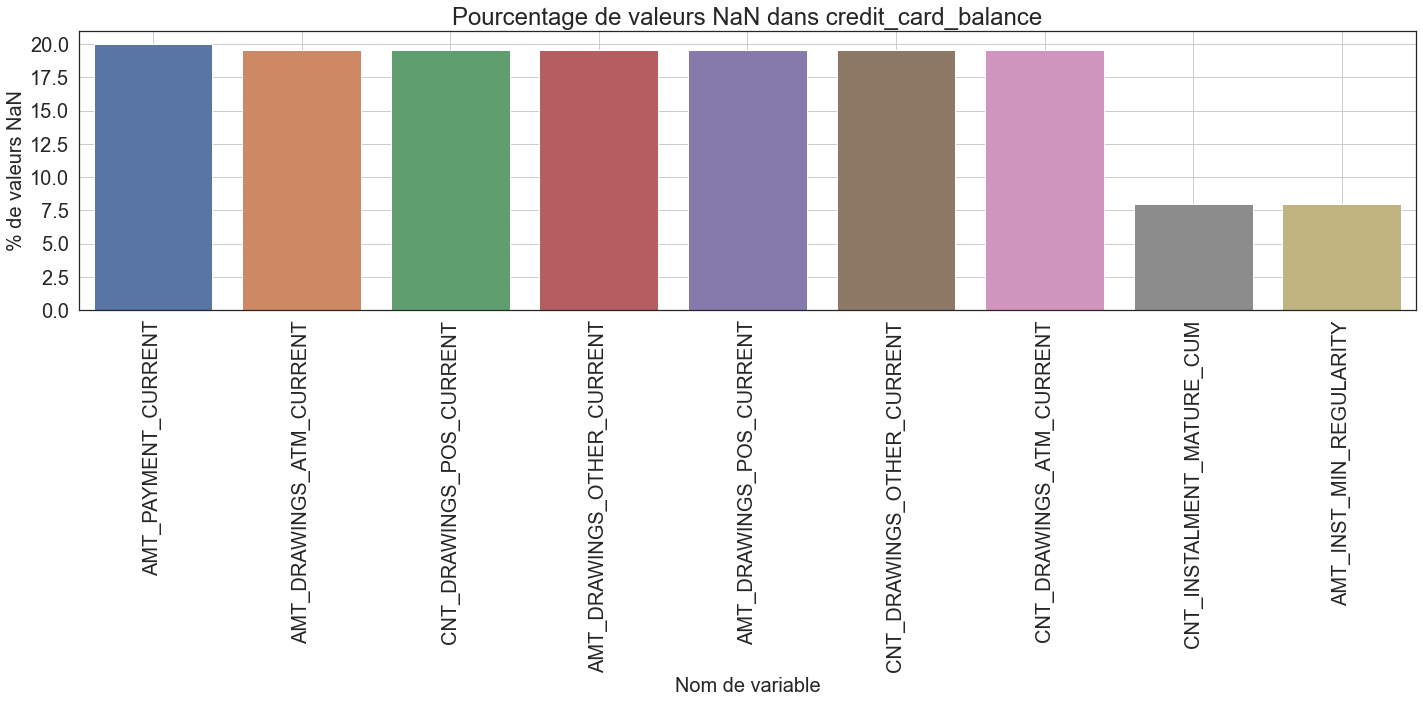

In [8]:
# Réprésentation visuelle des valeurs manquantes
df_nan_ccbal = plot_nan_percent(nan_df_create(cc_balance), 'credit_card_balance',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10)) 
df_nan_ccbal

**Observations** :

- Sur les 23 variables, 9 d'entre elles contiennent des valeurs NaN.

**Préparation du dataframe de travail**

In [9]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
print('Création dataframe de travail : merge TARGET avec dataframe cc_balance')
cc_balance_merged = application_train.iloc[:, :2].merge(cc_balance,
                                                        on='SK_ID_CURR',
                                                        how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe cc_balance
-------------------------------------------------------------------------------


### 3.1.2. Analyse exploratoire univariée

**Distribution des variables catégorielles**
***

Nous allons maintenant représenter graphiquement certaines des variables catégorielles, et voir leur impact sur TARGET.

In [10]:
# Liste des variables qualitatives
cols_cat_ccbal = \
    cc_balance_merged.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_ccbal

['NAME_CONTRACT_STATUS']

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_STATUS**</span>

État du contrat au cours du mois.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_STATUS' sont :
[nan 'Active' 'Completed' 'Signed' 'Sent proposal' 'Refused' 'Demand'
 'Approved']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Active           3116673
Completed         100031
Signed              9939
Demand               843
Sent proposal        460
Refused               14
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_STATUS = 8


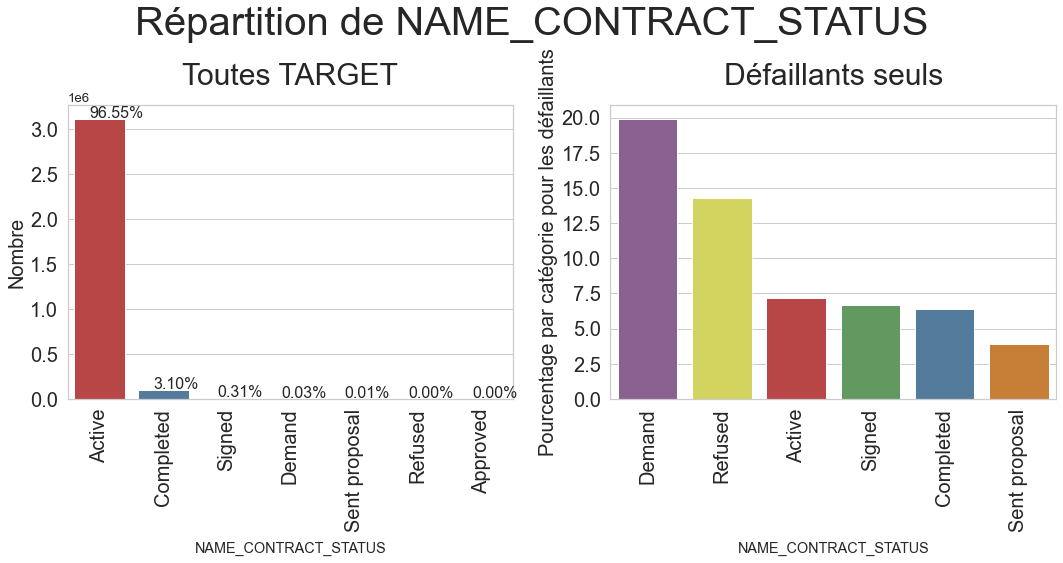

In [11]:
# Let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(cc_balance_merged,
                                             'NAME_CONTRACT_STATUS',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
plot_categorical_variables_bar(cc_balance_merged,
                                   column_name='NAME_CONTRACT_STATUS',
                                   figsize=(15, 8), rotation=90,
                                   horizontal_adjust=0.25,
                                   fontsize_percent=16,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38'],
                                   palette2=['#905998', '#e6e64c',
                                             '#cb3335', '#59a257',
                                             '#477ca8', '#df7f20'])

**Observations** :

- La majorité des états des contrats des prêts sont Actif ou Terminé.
- Pour les défaillants, l'état des contrat sont demandé, réfusé puis actif ou signé.
- Les non-défaillants ont plus de prêts actifs que les défaillants.

**Distribution des variables quantitatives**
***

In [12]:
# Liste des variables quantitatives
cols_num = \
    cc_balance_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF']

Nous commonçons par le regroupement du champ 'SK_ID_PREV' et agréger avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du demandeur.

In [13]:
cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV').mean()

<span style='background:PaleGreen'>**Variable AMT_BALANCE**</span>

Cette variable indique le montant moyen du solde qu'une personne avait habituellement sur son compte de carte de crédit pour le prêt précédent.

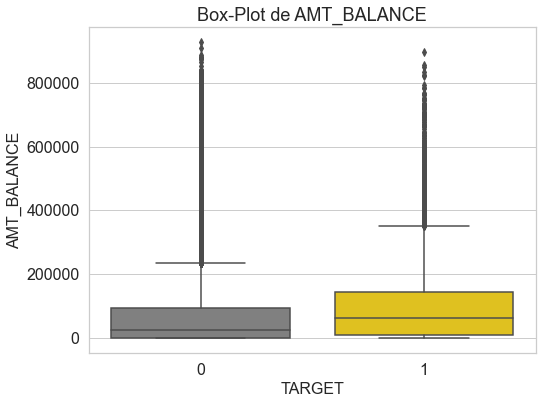

In [14]:
# Affiche boxplot
plot_continuous_variables(cc_balance_merged,
                                               'AMT_BALANCE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Le graphique ci-dessus montre que les défaillants ont une valeur d'AMT_BALANCE plus élevée que les non-défaillants. Cela pourrait signifier que le montant du crédit pour les défaillants pourrait aussi être relativement plus élevé que pour les non-défaillants.
- Nous constatons que les défaillants semblent ici aussi avoir un versement minimum plus élevé chaque mois par rapport aux non défaillants. Les défaillants ont des habitudes de dépenses et d'emprunt plus élevées que les non défaillants.

<span style='background:PaleGreen'>**Variable AMT_TOTAL_RECEIVABLE**</span>

Cette variable décrit la moyenne du montant total à recevoir sur le crédit précédent.

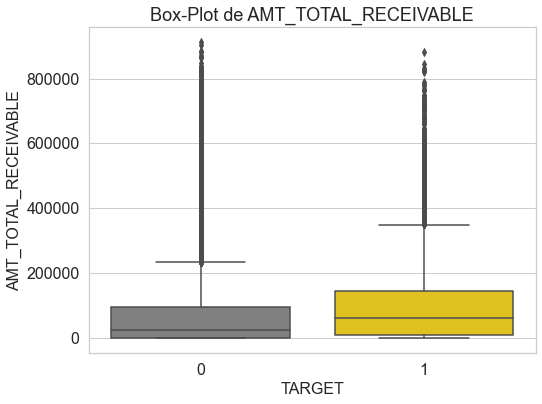

In [15]:
# Affiche Boxplot
plot_continuous_variables(cc_balance_merged,
                                               'AMT_TOTAL_RECEIVABLE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- En regardant le boxplot d'AMT_TOTAL_RECEIVABLE, nous constatons que les défaillants ont généralement un montant à recevoir plus élevé pour leur crédit précédent.

<span style='background:PaleGreen'>**Variable CNT_INSTALMENT_MATURE_CUM**</span>

La variable décrit le nombre moyen de versements effectués sur les crédits précédents.

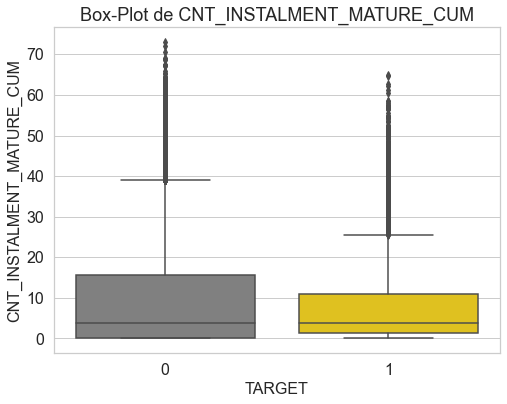

In [16]:
# Affiche Boxplot
plot_continuous_variables(cc_balance_merged,
                                               'CNT_INSTALMENT_MATURE_CUM',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

Ce graphique montre que les non-défaillants ont généralement une fourchette de valeurs plus élevée pour le nombre de versements payés que les défaillants.

<span style='background:PaleGreen'>**Variable MONTHS_BALANCE**</span>

Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente).

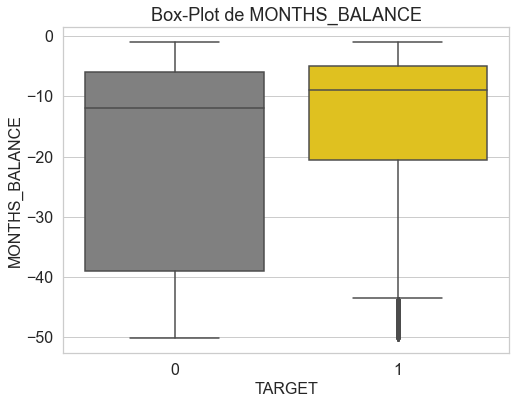

In [17]:
# Affiche Boxplot
plot_continuous_variables(cc_balance_merged,
                                               'MONTHS_BALANCE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Le mois du solde des défaillants sont plus récent que celui des non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_CREDIT_LIMIT_ACTUAL**</span>

Limite de la carte de crédit au cours du mois du crédit précédent.

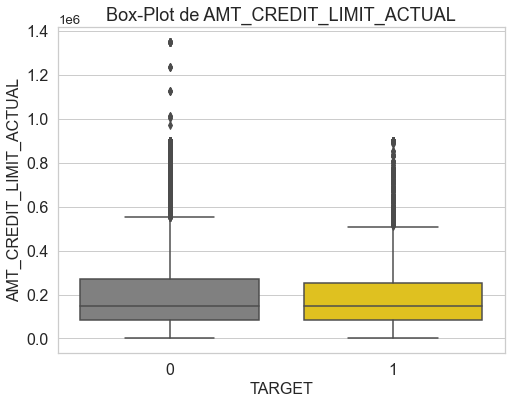

In [18]:
# Affiche Boxplot
plot_continuous_variables(cc_balance_merged,
                                               'AMT_CREDIT_LIMIT_ACTUAL',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- La limite de la carte de crédit est légèrement inférieure pour les non-défailants.

<span style='background:PaleGreen'>**Variable AMT_DRAWINGS_ATM_CURRENT**</span>

Montant retiré au guichet automatique pendant le mois du crédit précédent.

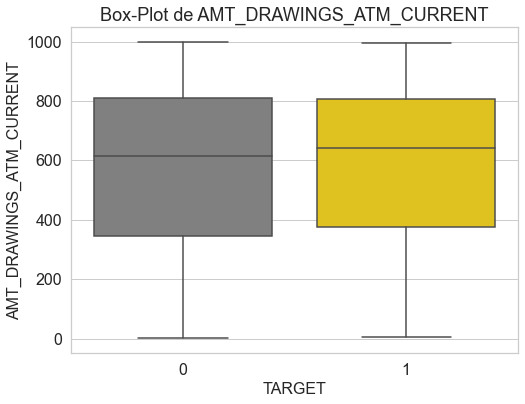

In [19]:
# Affiche Boxplot Zoom
plot_continuous_variables(cc_balance_merged,
                                               'AMT_DRAWINGS_ATM_CURRENT',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[0, 1000])

**Observations** :

- Le montant retiré au guichet automatique pendant le mois du crédit précédent est légèrement supérieur pour les défaillants que les non-défaillants.

<span style='background:PaleGreen'>**Variable AMT_PAYMENT_TOTAL_CURRENT**</span>

Combien le demandeur a-t-il payé au total pendant le mois sur le crédit précédent ?

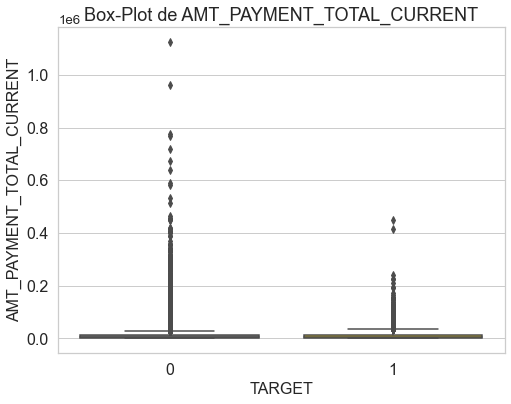

In [20]:
# Affiche Violinplot
plot_continuous_variables(cc_balance_merged,
                                               'AMT_PAYMENT_TOTAL_CURRENT',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Les demandeurs non-défaillants ont payé plsu au total pendant le mois sur le crédit précédent que les défaillants.

<span style='background:PaleGreen'>**Variable SK_DPD**</span>

DPD (jours de retard) au cours du mois sur le crédit précédent.

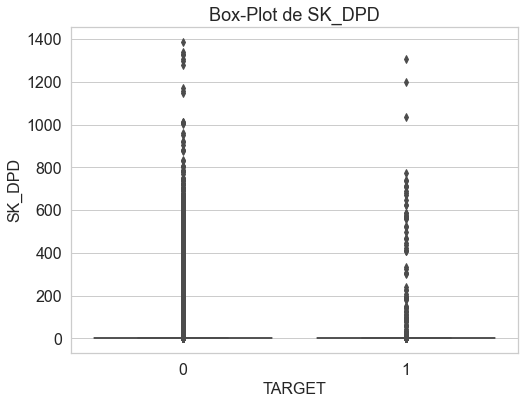

In [21]:
# Affiche boxplot
plot_continuous_variables(cc_balance_merged,
                                               'SK_DPD',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Peu de différence entre les défaillants et les non-défaillants.

### 3.1.3. Analyse exploratoire multivariée

**Corrélation entre les variables numériques**
***

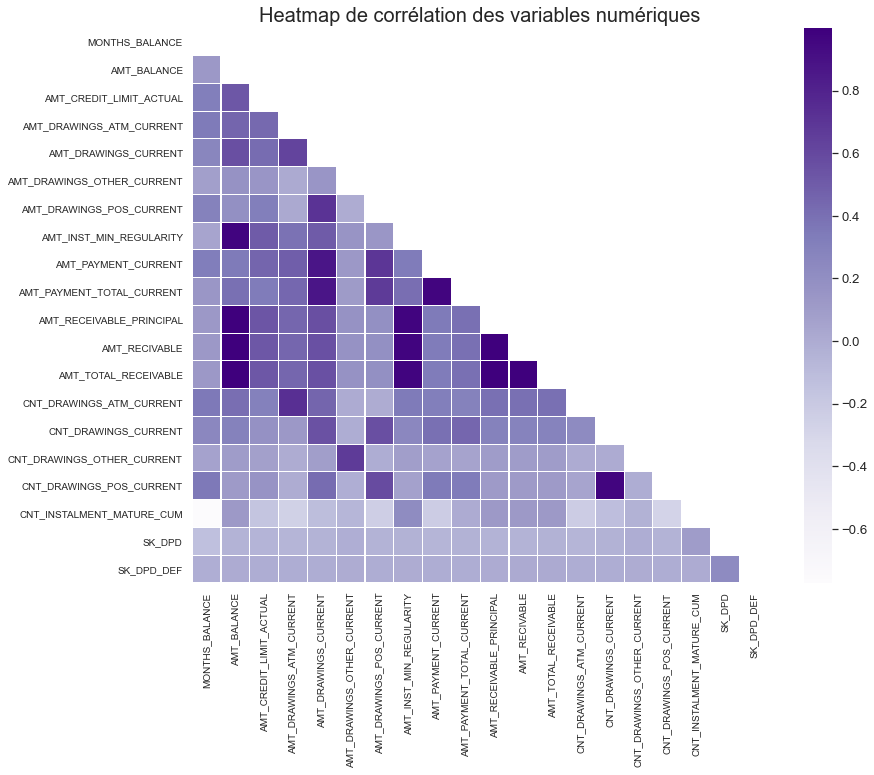

In [22]:
corr_mat = correlation_matrix(cc_balance_merged,
                                            ['SK_ID_CURR'],
                                            cmap='Purples',
                                            figsize=(13, 11))
corr_mat.plot_correlation_matrix()

In [23]:
# Seeing the top columns with highest phik-correlation with the target
# variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

Column Name,Phik-Correlation
AMT_BALANCE,0.117710
AMT_RECIVABLE,0.117688
AMT_TOTAL_RECEIVABLE,0.117667
AMT_RECEIVABLE_PRINCIPAL,0.117472
AMT_INST_MIN_REGULARITY,0.088280
MONTHS_BALANCE,0.082091
CNT_INSTALMENT_MATURE_CUM,0.052574
CNT_DRAWINGS_ATM_CURRENT,0.042586
CNT_DRAWINGS_CURRENT,0.040082
CNT_DRAWINGS_POS_CURRENT,0.028772


-------------------------------------------------------------------------------


**Interprétation** :

- La carte thermique montre la corrélation entre les variables du fichier credit_card_balance.csv.
- À partir de la matrice de corrélation, nous voyons des variables fortement corrélées. 
- Il s'agit de :
    - AMT_RECEIVABLE_PRINCIPLE,
    - AMT_RECIVABLE,
    - AMT_TOTAL_RECEIVABLE
    - et AMT_BALANCE.
- Nous observons également une forte corrélation entre ces 2 variables :
    - AMT_PAYMENT_TOTAL_CURRENT,
    - et AMT_PAYMENT_CURRENT.
- Les ensembles des 2ème et 3ème variables en corrélation sont compréhensibles car ils ont plus ou moins la même histoire.

## 3.2. Fichier installments_payments.csv

- Le fichier **installments_payments.csv** présente l'historique de remboursement de chacun des prêts que le demandeur a contractés auprès de Home Credit Group.
- Le tableau contient des variables telles que le montant des versements, combien le demandeur a payé pour chaque versement, etc.

### 3.2.1. Statistiques

In [24]:
# Résumé des variables
desc_bureau = description_variables(installments_payments)
desc_bureau

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
type,int64,int64,float64,int64,float64,float64,float64,float64
nb_nan,0.0,0.0,0.0,0.0,0.0,2905.0,0.0,2905.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.002669,0.0,0.002669
count,13605401.0,13605401.0,13605401.0,13605401.0,13605401.0,13602496.0,13605401.0,13602496.0
mean,1903364.969549,278444.881738,0.856637,18.870896,-1042.269992,-1051.113684,17050.906989,17238.22325
std,536202.905546,102718.310411,1.035216,26.664067,800.946284,800.585883,50570.254429,54735.783981
min,1000001.0,100001.0,0.0,1.0,-2922.0,-4921.0,0.0,0.0
25%,1434191.0,189639.0,0.0,4.0,-1654.0,-1662.0,4226.085,3398.265
50%,1896520.0,278685.0,1.0,8.0,-818.0,-827.0,8884.08,8125.515
75%,2369094.0,367530.0,1.0,19.0,-361.0,-370.0,16710.21,16108.425


**Observations** :

- Il y a environ 13,6 millions de points de données et 8 variables uniques dans le fichier installments_payments.csv.
- Chaque ligne représente l'historique des versements liés à un prêt particulier que le demandeur a eu précédemment avec Home Credit Group.
- Il y a 997000 prêts antérieurs uniques dans le fichier installments_payments. Ils appartiennent à 339000 SK_ID_CURR uniques, qui sont les ID des demandeurs du prêt actuel.

**Valeurs manquantes**

Nombre de variables avec valeurs manquantes : 2


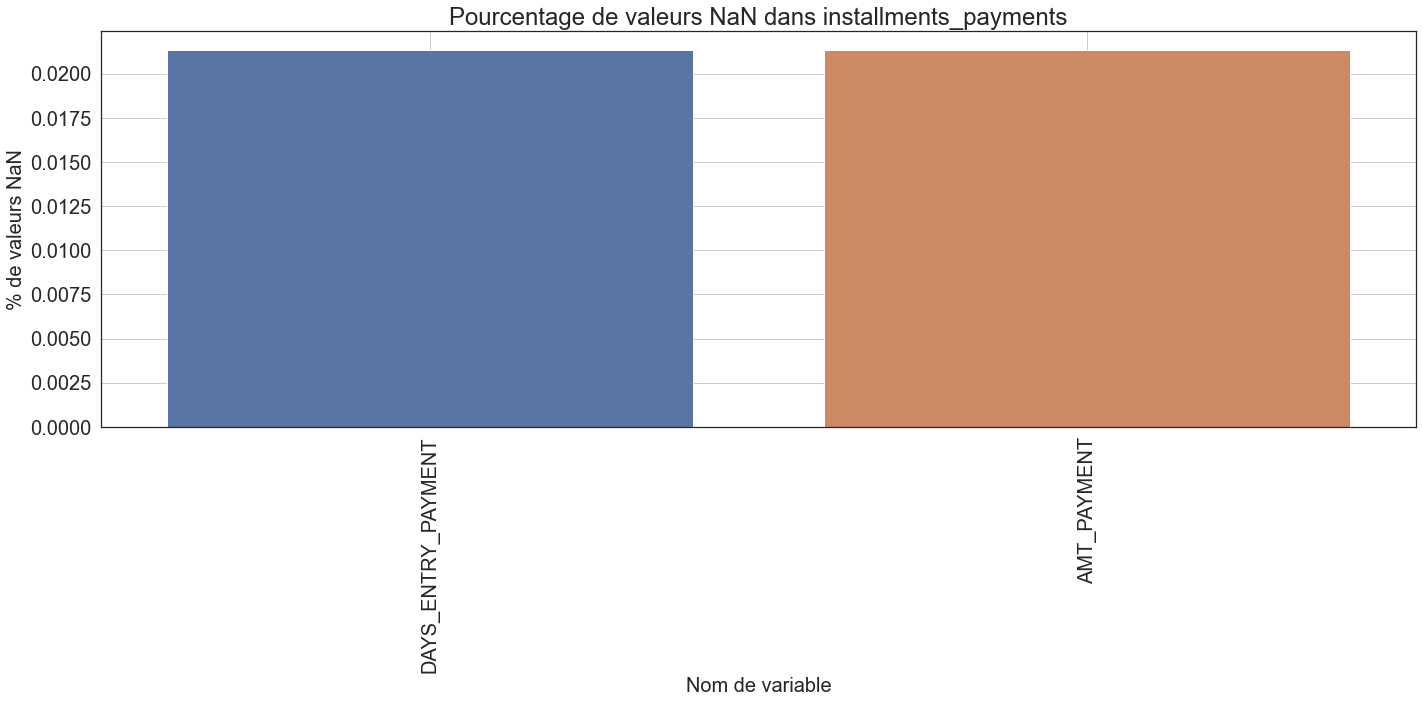

In [25]:
# Réprésentation visuelle des valeurs manquantes
df_nan_instpaie = plot_nan_percent(nan_df_create(installments_payments), 'installments_payments',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))
df_nan_instpaie

**Observations** :

- Il n'y a que 2 variables qui contiennent des valeurs NaN sur les 8 variables de installments_payments.
- Ces variables contiennent également une proportion très minime de valeurs NaN.

**Préparation du dataframe de travail**

In [26]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
part1 = 'Création dataframe de travail : merge TARGET '
print(part1 + 'avec dataframe installments_payments')
installments_merged = \
    application_train.iloc[:, :2].merge(installments_payments,
                                        on='SK_ID_CURR',
                                        how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe installments_payments
-------------------------------------------------------------------------------


### 3.2.2. Analyse exploratoire univariée

**Distribution des variables quantitatives**
***

In [27]:
# Liste des variables quantitatives
cols_num_instpaie = \
    installments_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num_instpaie

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT']

Nous commonçons par le regroupement du champ 'SK_ID_PREV' et agréger avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du demandeur.

In [28]:
installments_merged = installments_merged.groupby('SK_ID_PREV').mean()

<span style='background:PaleGreen'>**Variable DAYS_INSTALMENT**</span>

Cette variable indique les jours où le versement du crédit précédent devait être payé.

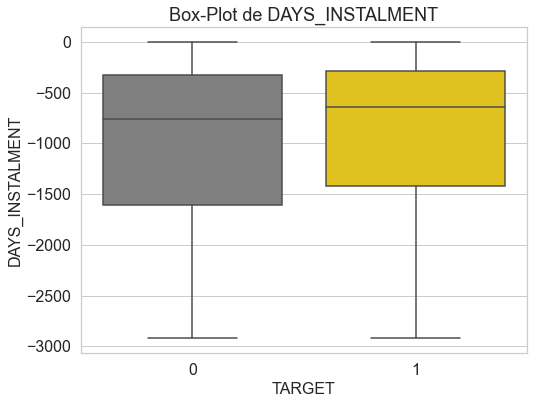

In [29]:
# Affiche Boxplot
plot_continuous_variables(installments_merged,
                                               'DAYS_INSTALMENT',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Les jours où le versement du précédent devait être payé est inférieur pour les défaillants.

<span style='background:PaleGreen'>**Variable DAYS_ENTRY_PAYMENT**</span>

Cette variable indique les jours où le versement du crédit précédent a été effectivement payé.

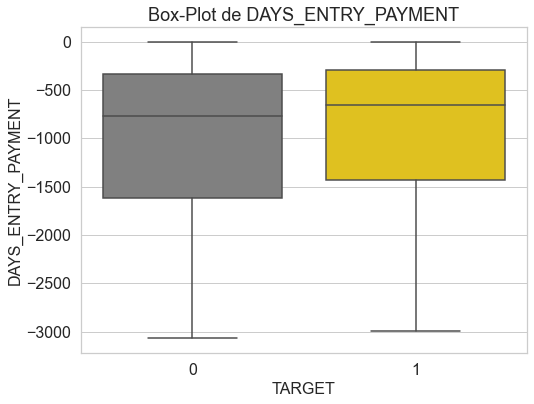

In [30]:
# Affiche Boxplot
plot_continuous_variables(installments_merged,
                                               'DAYS_ENTRY_PAYMENT',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Les deux graphiques ci-dessus montrent une tendance similaire : les mauvais payeurs ont tendance à avoir moins de jours depuis leur dernier paiement.

<span style='background:PaleGreen'>**Variable NUM_INSTALMENT_NUMBER**</span>

Sur quel versement nous observons le paiement.

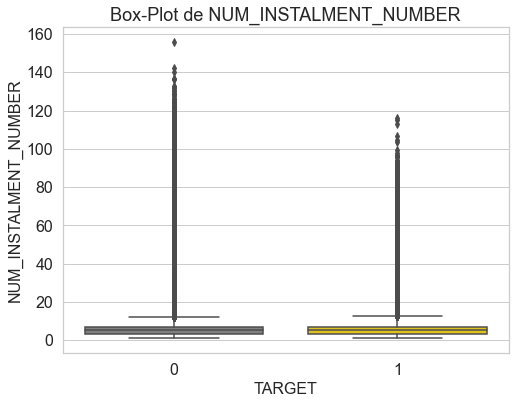

In [31]:
# Affiche Boxplot
plot_continuous_variables(installments_merged,
                                               'NUM_INSTALMENT_NUMBER',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Peu de différence.

### 3.2.3. Analyse exploratoire multivariée

**Corrélation entre les variables numériques**
***

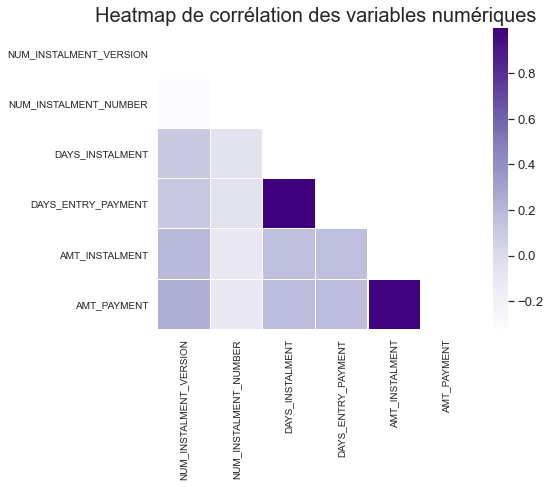

In [32]:
corr_mat = correlation_matrix(installments_merged,
                                            ['SK_ID_CURR'],
                                            cmap='Purples',
                                            figsize=(8, 7))
corr_mat.plot_correlation_matrix()

In [33]:
# Seeing the top columns with highest phik-correlation with the target
# variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
-------------------------------------------------------------------------------
Les variables ayant les valeurs les plus élevées de Phik-corrélation avec la variable cible sont les suivantes :


Column Name,Phik-Correlation
DAYS_ENTRY_PAYMENT,0.041427
DAYS_INSTALMENT,0.041410
NUM_INSTALMENT_NUMBER,0.023453
AMT_INSTALMENT,0.005077
NUM_INSTALMENT_VERSION,0.004666
AMT_PAYMENT,0.004632


-------------------------------------------------------------------------------


**Interprétation** :

- À partir de la matrice de corrélation, nous voyons un couple de variables fortement corrélées. Il s'agit de :
    - AMT_INSTALMENT et AMT_PAYMENT,
    - DAYS_INSTALMENT et DAYS_ENTRY_PAYMENT.
- Ces deux ensembles de variables corrélées sont compréhensibles, car il s'agit en fait des variables relatives à la date à laquelle l'acompte devait être payé par rapport à la date à laquelle il a été payé.
- Ces variables seront utiles pour créer de nouveaux ensembles de variables totalement non corrélées.

## 3.3. Fichier POS_CASH_balance.csv

- Ce fichier **POS_CASH_balance.csv** contient les instantanés des soldes mensuels des prêts aux points de vente et des prêts en espèces que le demandeur a obtenus auprès de Home Credit Group.
- Le fichier contient des colonnes telles que le statut du contrat, le nombre de versements restants, etc.

### 3.3.1. Statistiques

In [34]:
# Résumé des variables
desc_bureau = description_variables(POS_CASH_balance)
desc_bureau

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
type,int64,int64,int64,float64,float64,object,int64,int64
nb_nan,0.0,0.0,0.0,26071.0,26087.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.032584,0.032604,0.0,0.0,0.0
count,10001358.0,10001358.0,10001358.0,9975287.0,9975271.0,10001358,10001358.0,10001358.0
unique,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1903216.598957,278403.863306,-35.012588,17.08965,10.48384,NaN,11.606928,0.654468
std,535846.530722,102763.74509,26.06657,11.995056,11.109058,NaN,132.714043,32.762491
min,1000001.0,100001.0,-96.0,1.0,0.0,NaN,0.0,0.0


**Observations** :

- Le fichier POSH_CASH_BALANCE.csv contient environ 10 millions de points de données, où chaque ligne correspond à l'instantané mensuel de l'état du POS et du prêt d'argent précédent que le demandeur a eu avec Home Credit Group.
- Elle se compose de 8 variables, dont deux sont SK_ID_CURR et SK_ID_PREV.
- Il y a 936000 identifiants uniques de prêts précédents dans le fichier, qui correspondent à 337000 demandeurs actuels uniques (SK_ID_CURR).

**Valeurs manquantes**

Nombre de variables avec valeurs manquantes : 2


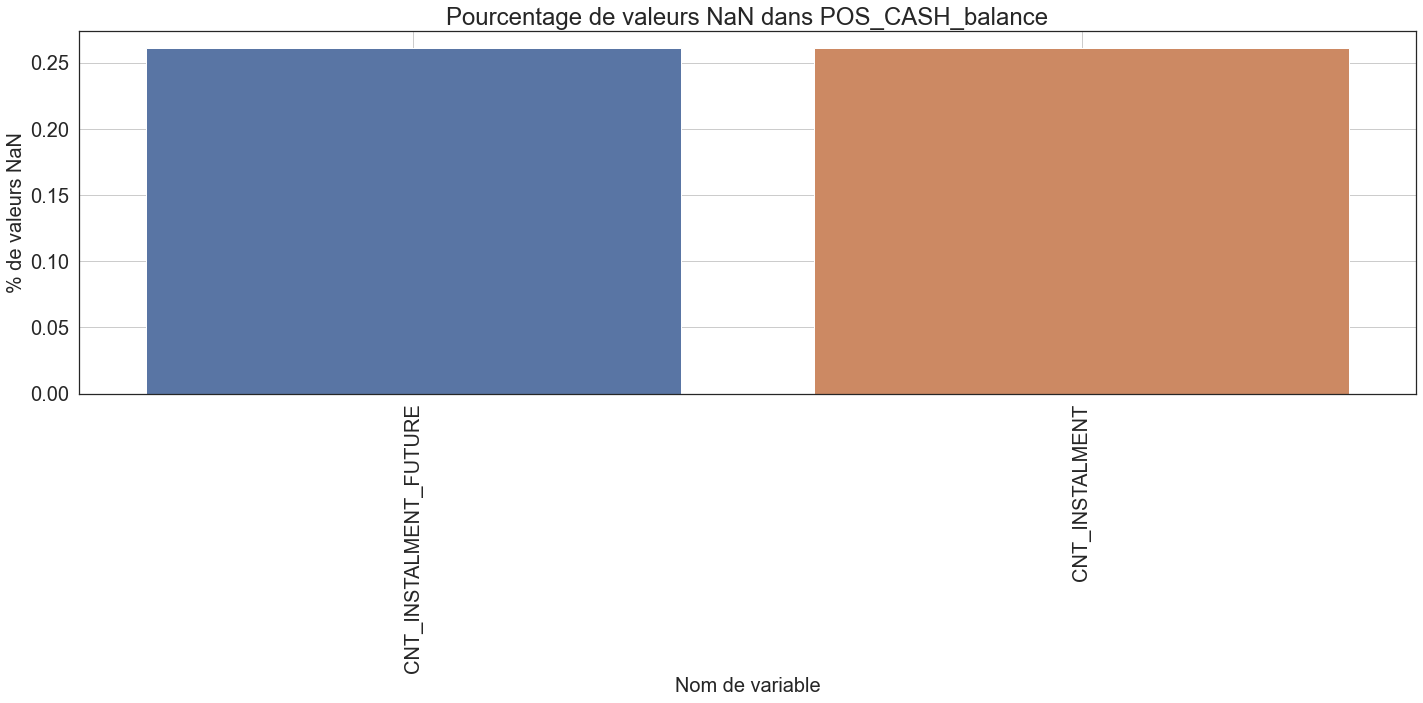

In [35]:
# Réprésentation visuelle des valeurs manquantes
df_nan_posh = plot_nan_percent(nan_df_create(POS_CASH_balance), 'POS_CASH_balance',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))
df_nan_posh

**Observations** :

- Il y a seulement 2 variables qui contiennent des valeurs NaN des 8 variables de POS_CASH_balance.

**Préparation du dataframe de travail**

In [36]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
var1 = 'Création dataframe de travail : merge TARGET '
print(var1 + 'avec dataframe POS_CASH_balance')
pos_cash_merged = application_train.iloc[:, :2].merge(POS_CASH_balance,
                                                      on='SK_ID_CURR',
                                                      how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe POS_CASH_balance
-------------------------------------------------------------------------------


### 3.3.2. Analyse exploratoire univariée

**Distribution des variables catégorielles**
***

Nous commonçons par le regroupement du champ 'SK_ID_PREV' et agréger avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du demandeur.

In [37]:
# Liste des variables qualitatives
cols_cat_posh = \
    pos_cash_merged.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_posh

['NAME_CONTRACT_STATUS']

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_STATUS**</span>

État du contrat au cours du mois.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_STATUS' sont :
['Active' 'Completed' 'Returned to the store' 'Signed' nan 'Approved'
 'Demand' 'Amortized debt' 'Canceled' 'XNA']
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_STATUS = 10


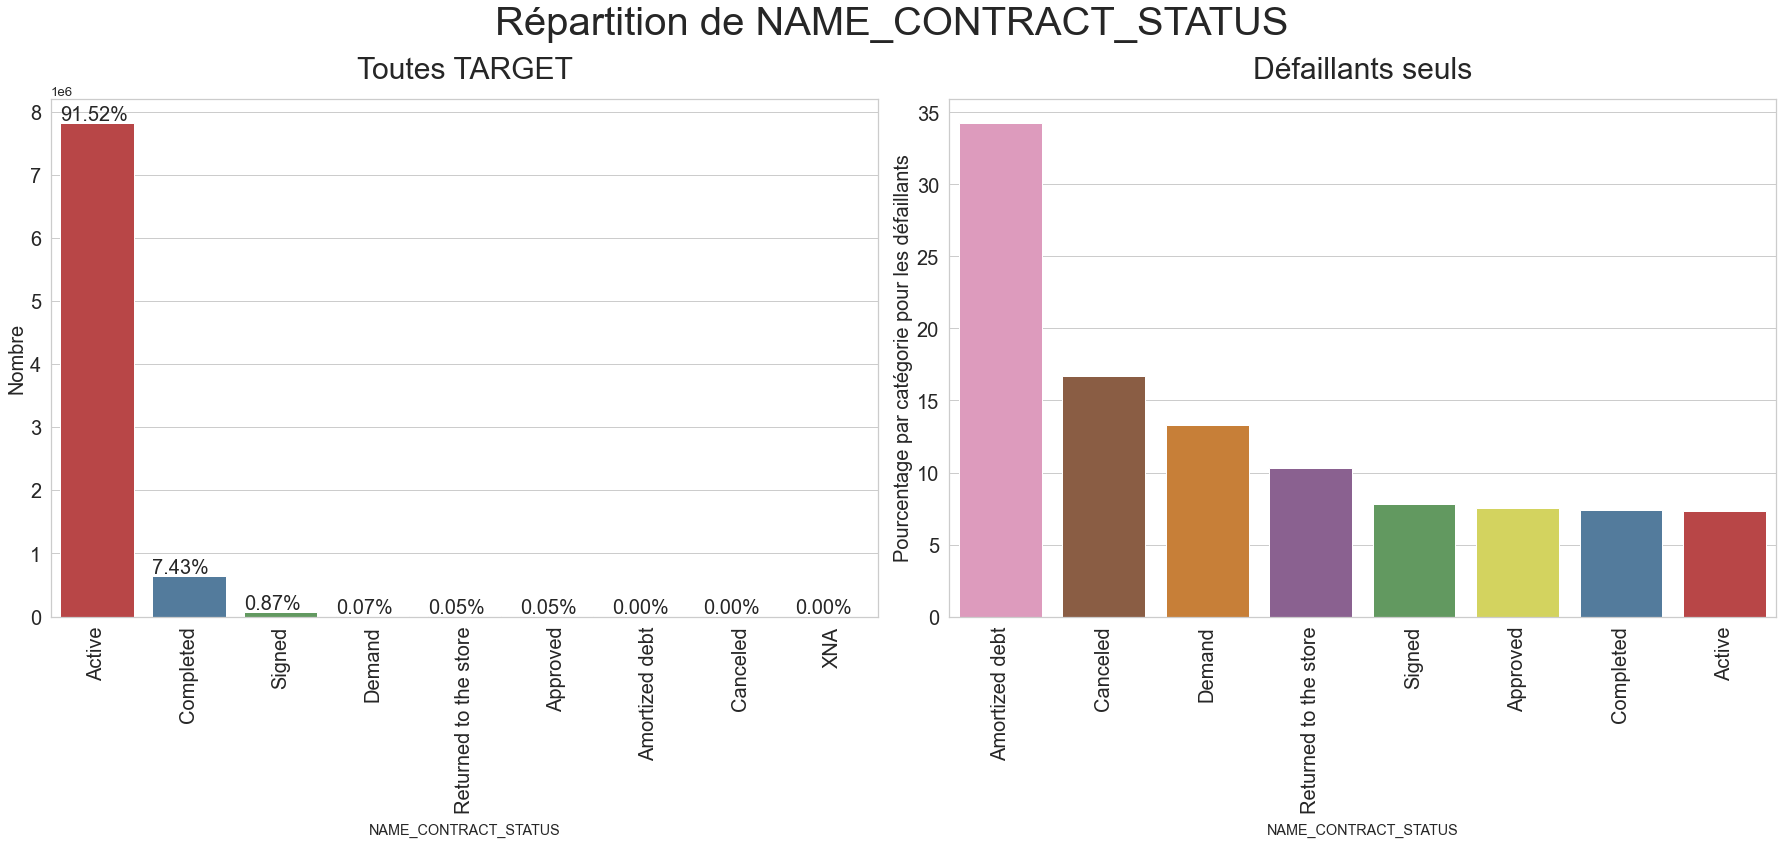

In [38]:
# Let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(pos_cash_merged,
                                             'NAME_CONTRACT_STATUS')

# Plotting the Bar Plot for the Column
plot_categorical_variables_bar(pos_cash_merged,
                                   column_name='NAME_CONTRACT_STATUS',
                                   figsize=(25, 12), rotation=90,
                                   fontsize_percent=20,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998',
                                             '#df7f20', '#e6e64c',
                                             '#965a38', '#e890be',
                                             '#999999'],
                                   palette2=['#e890be', '#965a38',
                                             '#df7f20', '#905998',
                                             '#59a257', '#e6e64c',
                                             '#477ca8', '#cb3335'])

**Observations** :

- La majorité des états des contrats des prêts sont Actif ou Terminé.
- Pour les défaillants, l'état des contrat sont en priorité tous sauf ceux de la majorité des demandeurs Actifs ou Terminés.
- Les non-défaillants ont plus de prêts actifs que les défaillants.

**Distribution des variables quantitatives**
***

In [39]:
# Liste des variables quantitatives
cols_num_posh = \
    pos_cash_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num_posh

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF']

<span style='background:PaleGreen'>**Variable MONTHS_BALANCE**</span>

Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente).

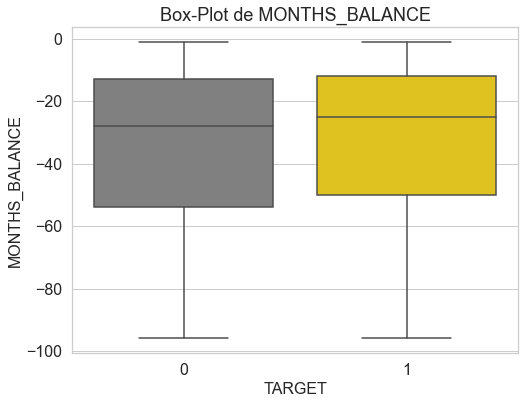

In [40]:
# Affiche Violinplot
plot_continuous_variables(pos_cash_merged,
                                               'MONTHS_BALANCE',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Peu de différence.

<span style='background:PaleGreen'>**Variable CNT_INSTALMENT**</span>

Durée du crédit précédent (peut changer avec le temps).

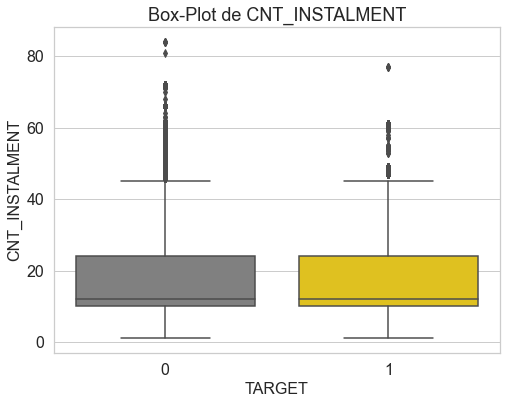

In [41]:
# Affiche Boxplot
plot_continuous_variables(pos_cash_merged,
                                               'CNT_INSTALMENT',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Peu de différence.

<span style='background:PaleGreen'>**Variable SK_DPD**</span>

DPD (jours de retard) au cours du mois du crédit précédent.

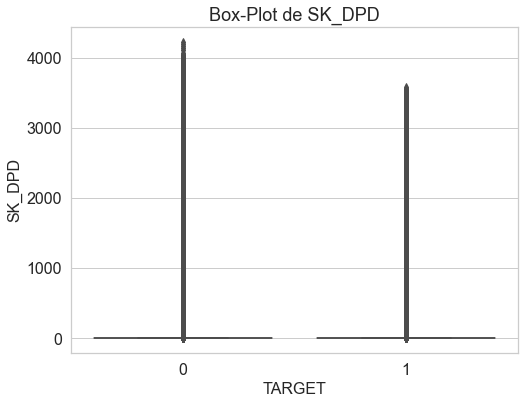

In [42]:
# Affiche boxplot
plot_continuous_variables(pos_cash_merged,
                                               'SK_DPD',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Peu de différence.

### 3.3.3. Analyse exploratoire multivariée

**Corrélation entre les variables numériques**

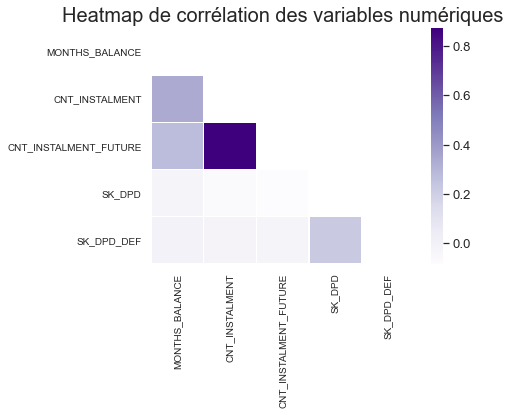

In [43]:
corr_mat = correlation_matrix(pos_cash_merged,
                                            ['SK_ID_CURR', 'SK_ID_PREV'],
                                            cmap='Purples',
                                            figsize=(7, 6))
corr_mat.plot_correlation_matrix()

In [44]:
# Seeing the top columns with highest phik-correlation with the target
# variable in pos_cash_merged table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
-------------------------------------------------------------------------------
Les variables ayant les valeurs les plus élevées de Phik-corrélation avec la variable cible sont les suivantes :


Column Name,Phik-Correlation
CNT_INSTALMENT_FUTURE,0.033194
CNT_INSTALMENT,0.030947
MONTHS_BALANCE,0.027391
SK_DPD,0.012773
SK_DPD_DEF,0.010539


-------------------------------------------------------------------------------


**Interprétation** :

- A partir de la matrice de corrélation, nous avons un ensemble de variables modérément corrélées, qui sont : 
    - CNT_INSTALMENT et CNT_INSTALMENT_FUTURE.

## 3.4. Fichier previous_application.csv

- Ce fichier **previous_application.csv** contient les données statiques du précédent prêt que le demmdeur a eu avec Home Credit. 

### 3.4.1. Statistiques

In [45]:
# Résumé des variables
desc_bureau = description_variables(previous_application)
desc_bureau

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
type,int64,int64,object,float64,float64,float64,float64,float64,object,int64,object,int64,float64,float64,float64,object,object,int64,object,object,object,object,object,object,object,object,int64,object,float64,object,object,float64,float64,float64,float64,float64,float64
nb_nan,0.0,0.0,0.0,372235.0,0.0,1.0,895844.0,385515.0,0.0,0.0,0.0,0.0,895844.0,1664263.0,1664263.0,0.0,0.0,0.0,0.0,0.0,820405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372230.0,0.0,346.0,673065.0,673065.0,673065.0,673065.0,673065.0,673065.0
%_nan,0.0,0.0,0.0,0.602342,0.0,0.000002,1.449635,0.623832,0.0,0.0,0.0,0.0,1.449635,2.693073,2.693073,0.0,0.0,0.0,0.0,0.0,1.327561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.602334,0.0,0.00056,1.089139,1.089139,1.089139,1.089139,1.089139,1.089139
count,1670214.0,1670214.0,1670214,1297979.0,1670214.0,1670213.0,774370.0,1284699.0,1670214,1670214.0,1670214,1670214.0,774370.0,5951.0,5951.0,1670214,1670214,1670214.0,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214.0,1670214,1297984.0,1670214,1669868,997149.0,997149.0,997149.0,997149.0,997149.0,997149.0
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,2,NaN,NaN,NaN,NaN,25,4,NaN,4,9,7,4,28,5,3,8,NaN,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,Y,NaN,NaN,NaN,NaN,XAP,Approved,NaN,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,NaN,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,1661739,NaN,NaN,NaN,NaN,922661,1036781,NaN,1033552,1353093,508970,1231261,950809,691011,1063666,719968,NaN,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1923089.135331,278357.174099,NaN,15955.120659,175233.86036,196114.021218,6697.402139,227847.279283,NaN,12.484182,NaN,0.996468,0.079637,0.188357,0.773503,NaN,NaN,-880.679668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.951115,NaN,16.054082,NaN,NaN,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.33257
std,532597.958696,102814.823849,NaN,14782.137335,292779.762387,318574.616546,20921.49541,315396.557937,NaN,3.334028,NaN,0.05933,0.107823,0.087671,0.100879,NaN,NaN,779.099667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7127.443459,NaN,14.567288,NaN,NaN,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1000001.0,100001.0,NaN,0.0,0.0,0.0,-0.9,0.0,NaN,0.0,NaN,0.0,-0.000015,0.034781,0.37315,NaN,NaN,-2922.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,0.0,NaN,NaN,-2922.0,-2892.0,-2801.0,-2889.0,-2874.0,0.0


**Observations** :

- Le fichier previous_application.csv est composée de 1.67 millions de lignes au total.
- Chaque ligne correspond à chacun des prêts précédents que le demandeur a eu avec Home Credit Group. 
- Il est possible pour un même demandeur de la demande actuelle d'avoir plusieurs prêts précédents avec Home Credit Group.
- Il y a 37 variables dans previous_application.csv, qui contiennent les détails sur le prêt précédent.

**Valeurs manquantes**

Nombre de variables avec valeurs manquantes : 16


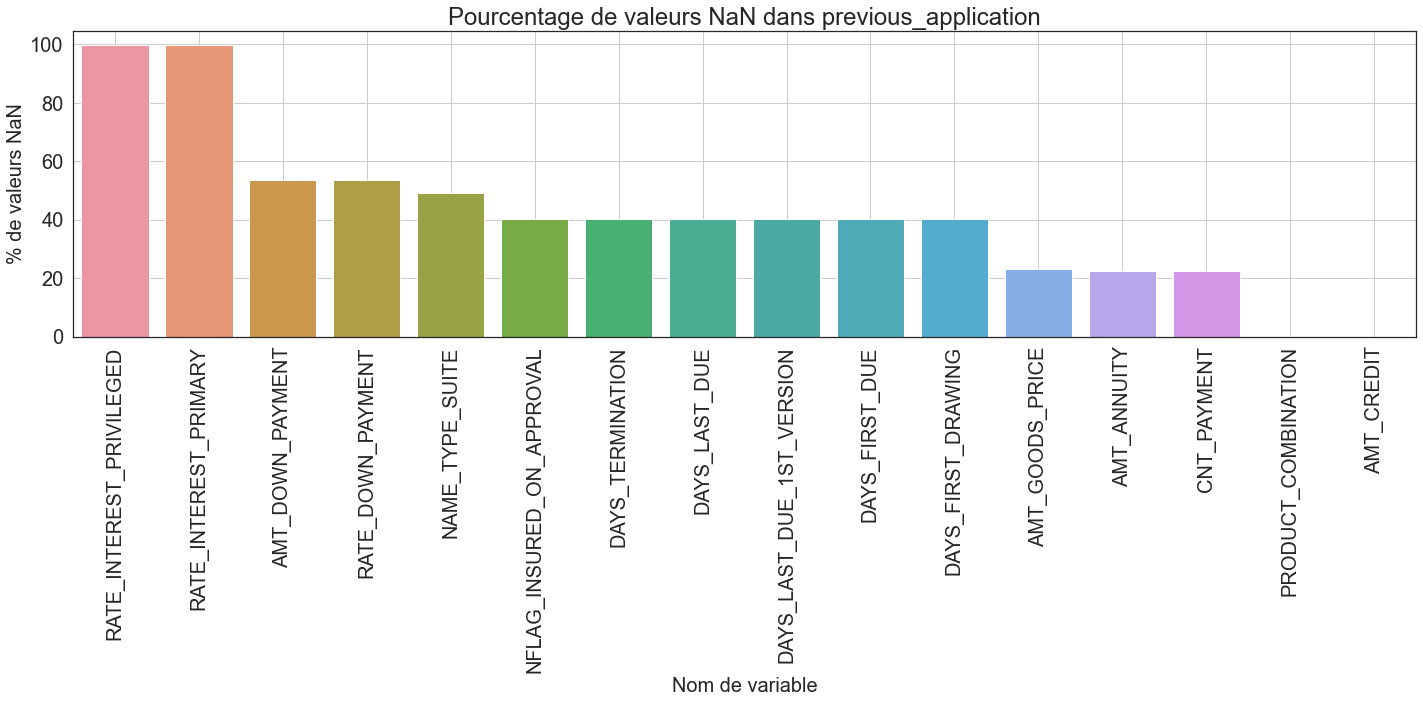

In [46]:
# Réprésentation visuelle des valeurs manquantes
df_nan_prev = plot_nan_percent(nan_df_create(previous_application), 'previous_application',
                                      grid=True, fontsize=20,
                                      figsize=(20, 10))
df_nan_prev

**Observations** :

- Il y a 16 variables sur les 37 variables qui contiennent des valeurs NaN.
- Deux de ces variables ont 99% de valeurs manquantes. 

**Préparation du dataframe de travail**

In [47]:
# Ajout de la variable TARGET pour la répartition
# défaillants/non-défaillants
print('-'*79)
var = 'Création dataframe de travail : merge TARGET '
print(var + 'avec dataframe previous_application')
prev_merged = application_train.iloc[:, :2].merge(previous_application,
                                                  on='SK_ID_CURR',
                                                  how='left')
print("-"*79)

-------------------------------------------------------------------------------
Création dataframe de travail : merge TARGET avec dataframe previous_application
-------------------------------------------------------------------------------


### 3.4.2. Analyse exploratoire univariée

**Distribution des variables catégorielles**
***

Nous allons maintenant représenter graphiquement certaines des variables catégorielles.

In [48]:
# Liste des variables qualitatives
cols_cat_prev = \
    prev_merged.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat_prev

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_TYPE**</span>

Type de produit contractuel (prêt d'argent ou prêt à la consommation [POS]...) de la demande précédente.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_TYPE' sont :
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_TYPE = 5


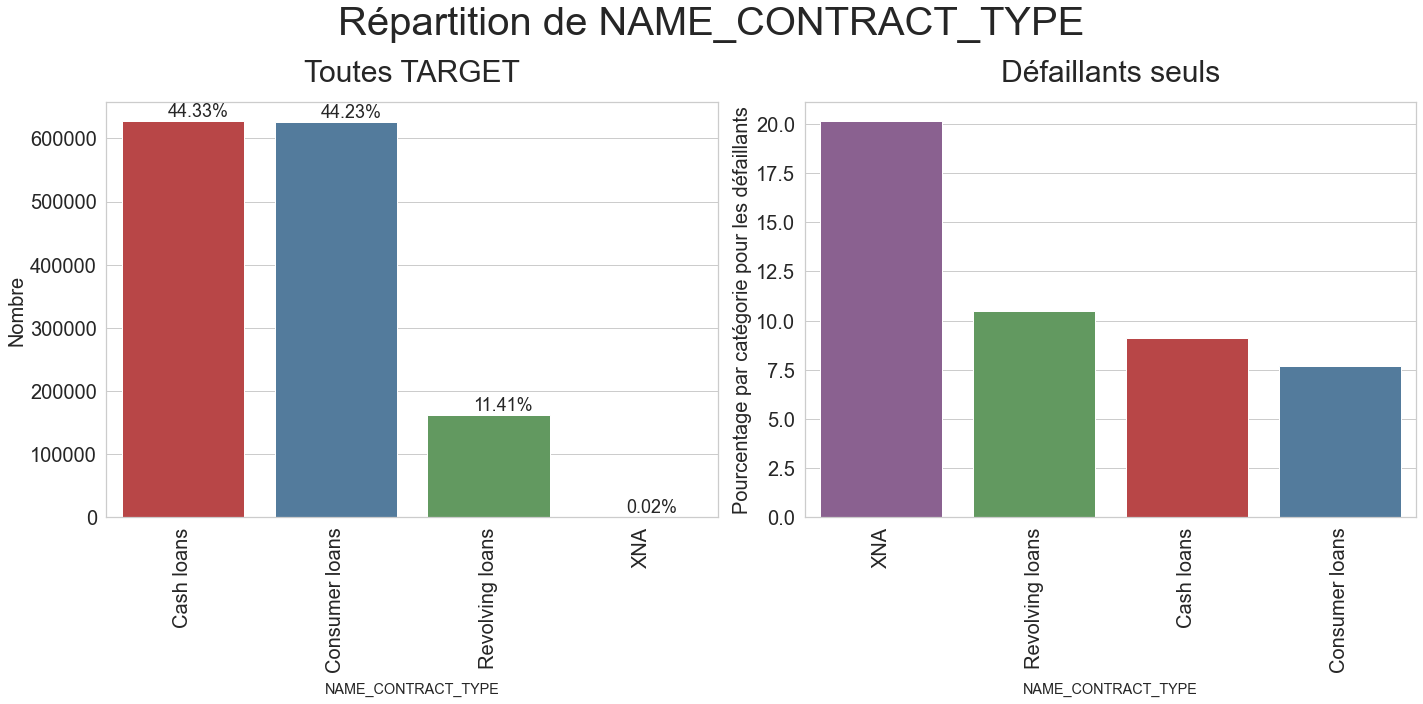

In [49]:
# Let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged,
                                             'NAME_CONTRACT_TYPE',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_CONTRACT_TYPE',
                                   horizontal_adjust=0.3,
                                   figsize=(20, 10), fontsize_percent=18,
                                   rotation=90,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#905998', '#59a257',
                                             '#cb3335', '#477ca8'])

**Observations** :

À partir des graphiques ci-dessus, nous pouvons observer ce qui suit :

- D'après le premier sous-graphe, nous voyons que la plupart des prêts précédents ont été des prêts d'argent ou des prêts à la consommation, qui correspondent à environ 44% des prêts chacun. 
- En regardant le deuxième sous-graphe, nous voyons que le pourcentage de défaillants pour le type de prêt XNA est le plus élevé, avec un taux de défaillance de 20%.

<span style='background:PaleGreen'>**Variable NAME_CONTRACT_STATUS**</span>

État du contrat (approuvé ou annulé ...) de la demande précédente.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_STATUS' sont :
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Approved        886099
Canceled        259441
Refused         245390
Unused offer     22771
Name: NAME_CONTRACT_STATUS, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_STATUS = 5


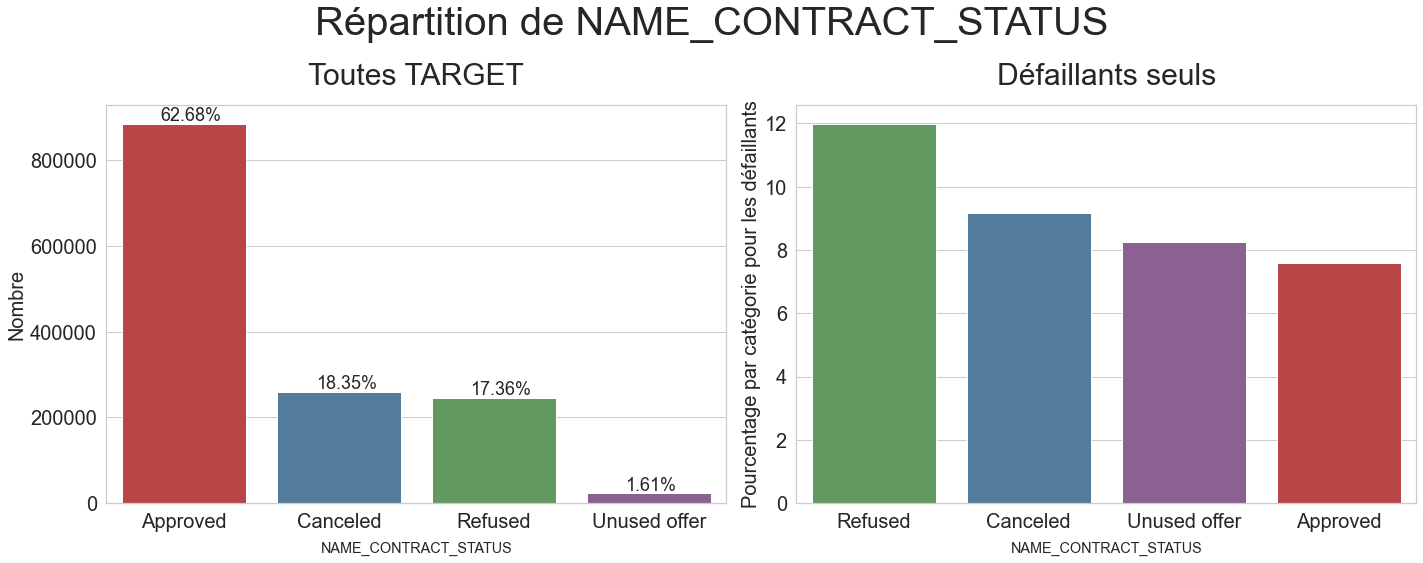

In [50]:
# Let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged,
                                             'NAME_CONTRACT_STATUS',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged,
                                   column_name='NAME_CONTRACT_STATUS',
                                   horizontal_adjust=0.25,
                                   figsize=(20, 8), fontsize_percent=18,
                                   palette1=['#cb3335', '#477ca8',
                                             '#59a257', '#905998'],
                                   palette2=['#59a257', '#477ca8',
                                             '#905998', '#cb3335'])

**Observations** :

D'après les graphiques ci-dessus, nous constatons que :

- Le type le plus courant de statut de contrat est le statut approuvé. Environ 63% des crédits précédents ont un statut approuvé. Les deux statuts les plus courants suivants sont Annulé et Refusé.
- Si l'on regarde le deuxième graphique pour le pourcentage de défaillants, on constate que les prêts qui avaient auparavant le statut Refusé ont tendance à être les plus défaillants dans les prêts actuels. Ils correspondent à environ 12% des défaillants de cette catégorie.

<span style='background:PaleGreen'>**Variable FLAG_LAST_APPL_PER_CONTRACT**</span>

- Indicateur si c'était la dernière demande pour le contrat précédent :
    - **Y** : OUI,
    - **N** : NON.
- Parfois par erreur du demandeur ou de notre greffier il peut y avoir plusieurs demandes pour un seul contrat.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'FLAG_LAST_APPL_PER_CONTRACT' sont :
['Y' nan 'N']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Y    1406387
N       7314
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour FLAG_LAST_APPL_PER_CONTRACT = 3


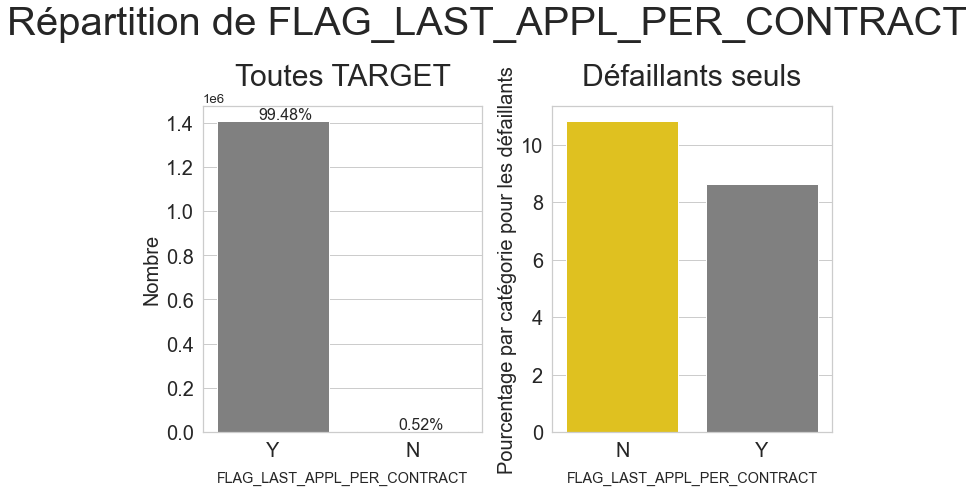

In [51]:
# Let us first see the unique categories of 'FLAG_LAST_APPL_PER_CONTRACT'
print_unique_categories(prev_merged,
                                             'FLAG_LAST_APPL_PER_CONTRACT',
                                             show_counts=True)

# Plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged,
                                   column_name='FLAG_LAST_APPL_PER_CONTRACT',
                                   horizontal_adjust=0.3,
                                   figsize=(10, 7), fontsize_percent=16,
                                   palette1=['Grey', 'Gold'],
                                   palette2=['Gold', 'Grey'])

**Observations** :

- La dernière demande pour le dernier contrat est de 99%, mais pour plus de 10% des défaillants, ce n'était pas la dernière demande.

**Distribution des variables quantitatives**
***

In [52]:
# Liste des variables quantitatives
cols_num_prev = \
    prev_merged.select_dtypes(include=[np.number]).columns.to_list()
cols_num_prev

['SK_ID_CURR',
 'TARGET',
 'SK_ID_PREV',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

<span style='background:PaleGreen'>**Variable DAYS_DECISION**</span>

Cette variable indique le nombre de jours, par rapport à la demande actuelle, où la décision a été prise concernant la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_DECISION
Pecentile 0 = -2922.0
Pecentile 2 = -2748.0
Pecentile 4 = -2612.0
Pecentile 6 = -2499.0
Pecentile 8 = -2383.0
Pecentile 10 = -2257.0
Pecentile 25 = -1313.0
Pecentile 50 = -582.0
Pecentile 75 = -271.0
Pecentile 100 = -1.0
-------------------------------------------------------------------------------


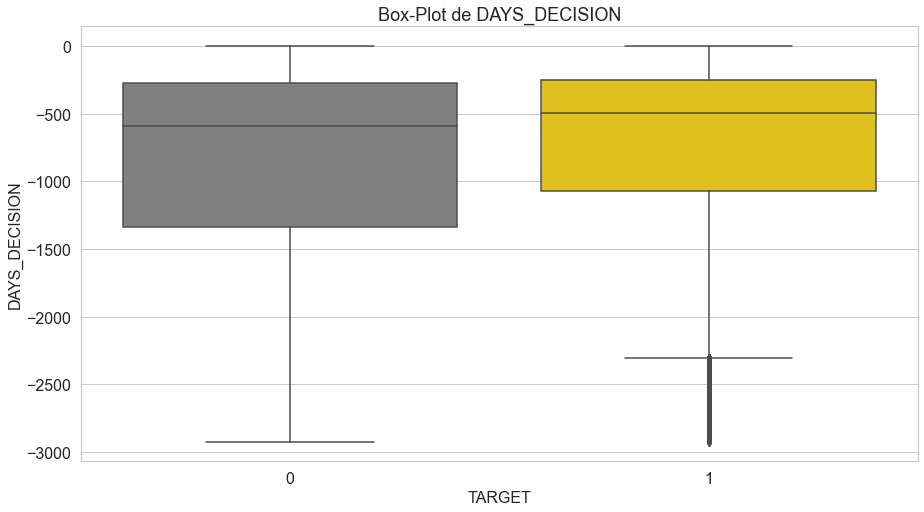

In [53]:
# Affiche les quantiles
print_percentiles(prev_merged, 'DAYS_DECISION',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
plot_continuous_variables(prev_merged,
                                               'DAYS_DECISION',
                                               plots=['box'],
                                               figsize=(15, 8))

**Observations** :

- Dans le graphique, nous remarquons que pour les défaillants, le nombre de jours depuis lequel la décision a été prise est un peu moins élevé que pour les non-défaillants.

<span style='background:PaleGreen'>**Variable DAYS_FIRST_DRAWING**</span>

Cette variable indique le nombre de jours depuis la demande actuelle où le premier déboursement de la demande précédente a été effectué.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_FIRST_DRAWING
Pecentile 0 = -2922.0
Pecentile 1 = -2451.0
Pecentile 2 = -1179.0
Pecentile 3 = -674.0
Pecentile 4 = -406.0
Pecentile 5 = -262.0
Pecentile 6 = -156.0
Pecentile 7 = 365243.0
Pecentile 8 = 365243.0
Pecentile 9 = 365243.0
Pecentile 10 = 365243.0
Pecentile 20 = 365243.0
Pecentile 40 = 365243.0
Pecentile 60 = 365243.0
Pecentile 80 = 365243.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


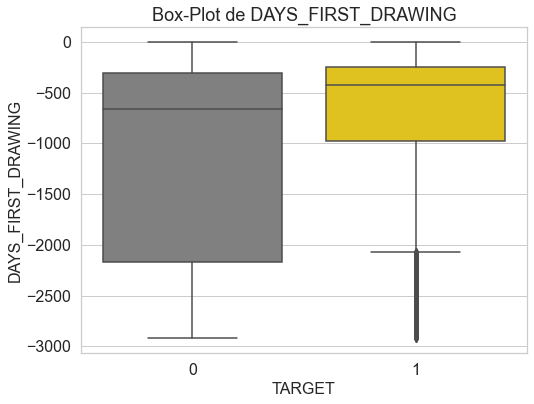

In [54]:
# Affiche les quantiles
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING',
                      percentiles=list(range(0, 11)) +
                      list(range(20, 101, 20)))
# Affiche boxplot
plot_continuous_variables(prev_merged,
                                               'DAYS_FIRST_DRAWING',
                                               plots=['box'],
                                               figsize=(8, 6),
                                               scale_limits=[-3000, 0])

**Observations** :

- En regardant les valeurs du quantile de DAYS_FIRST_DRAWING, il semble que la plupart des valeurs soient erronées.
- Si nous essayons d'analyser la distribution de cette variable en supprimant les ponts erronés, nous constatons que la plupart des défaillants ont eu leur premier versement sur un crédit précédent plus récemment que les non-défaillants. 

**Ces variables décrivent également le nombre de jours depuis l'application actuelle où certaines activités ont eu lieu.**

<span style='background:PaleGreen'>**Variable AMT_ANNUITY**</span>

Annuité de la demande précédente.

-------------------------------------------------------------------------------
Pecentiles de la variable AMT_ANNUITY
Pecentile 0 = 0.0
Pecentile 2 = 2250.0
Pecentile 4 = 2396.79
Pecentile 6 = 2984.4414
Pecentile 8 = 3375.0
Pecentile 10 = 3790.9890000000005
Pecentile 25 = 6257.8575
Pecentile 50 = 11223.765
Pecentile 75 = 20420.775
Pecentile 100 = 418058.145
-------------------------------------------------------------------------------


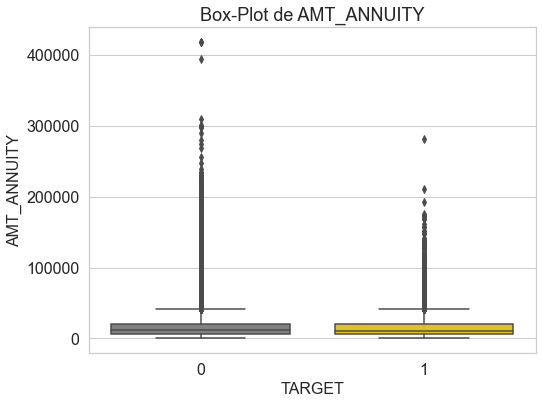

In [55]:
# Affiche les quantiles
print_percentiles(prev_merged, 'AMT_ANNUITY',
                      percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
# Affiche boxplot
plot_continuous_variables(prev_merged,
                                               'AMT_ANNUITY',
                                               plots=['box'],
                                               figsize=(8, 6))

**Observations** :

- Peu de différence.

### 3.4.3. Analyse exploratoire multivariée

**Corrélation entre les variables catégorielles**

**Phi-K Matrix**

-------------------------------------------------------------------------------


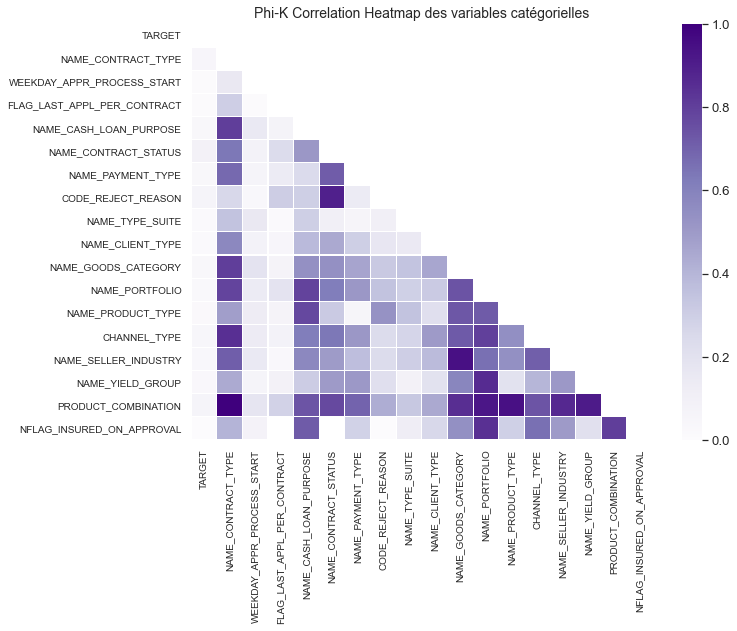

-------------------------------------------------------------------------------
Les catégories présentant les valeurs les plus élevées de la corrélation Phi-K avec la variable cible sont les suivantes :


Variable,Phik-Correlation
NAME_CONTRACT_STATUS,0.088266
PRODUCT_COMBINATION,0.063839
CODE_REJECT_REASON,0.062771
NAME_CONTRACT_TYPE,0.050859
CHANNEL_TYPE,0.050302
NAME_GOODS_CATEGORY,0.042951
NAME_CASH_LOAN_PURPOSE,0.040305
NAME_PAYMENT_TYPE,0.039752
NAME_SELLER_INDUSTRY,0.038077
NAME_YIELD_GROUP,0.034626


-------------------------------------------------------------------------------


In [56]:
cols_for_phik = ['TARGET'] + \
    prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() \
    + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik,
                                      figsize=(11, 9), fontsize=10)

**Interprétation** :

À partir de la matrice ci-dessus des valeurs du coefficient Phi-K pour les variables catégorielles, nous observons que :
- La variables PRODUCT_COMBINATION montre une association avec beaucoup d'autres variables telles que NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
- La variable NOM_GOODS_CATEGORY est également fortement associée à NOM_SELLER_INDUSTRY.
- Si nous examinons l'association avec la variable TARGET, nous constatons que les variables NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON font partie des variables les plus fortement associées et devraient faire l'objet d'une étude plus approfondie.

**Corrélation entre les variables numériques**

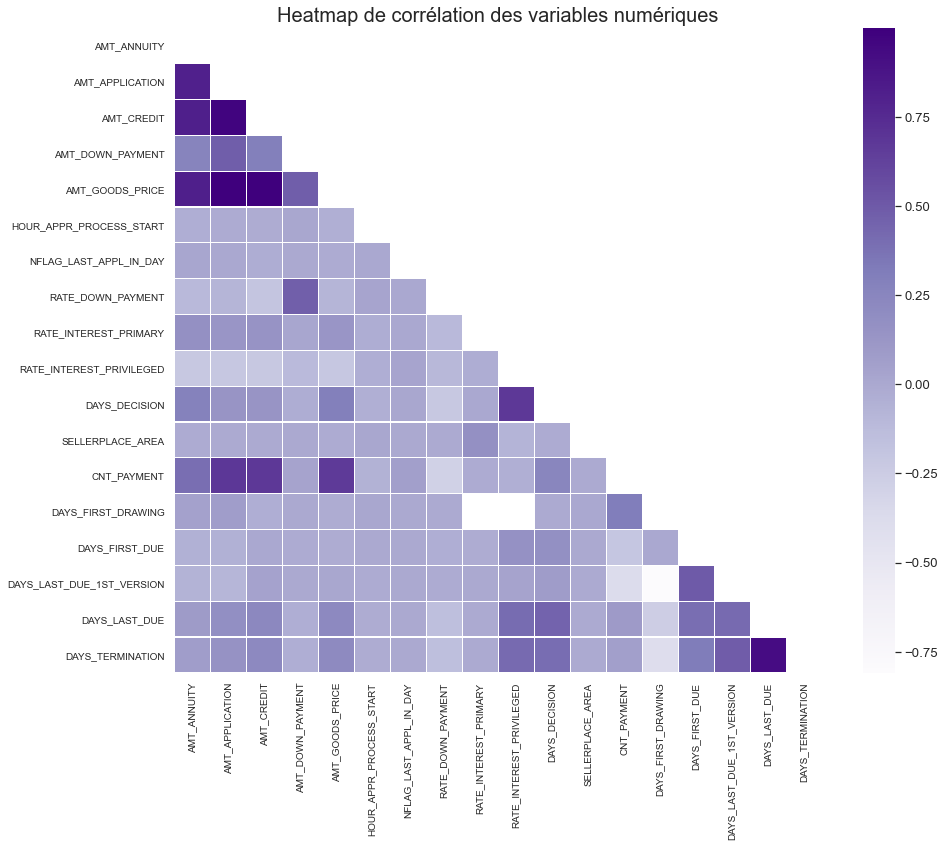

In [57]:
corr_mat = correlation_matrix(prev_merged,
                                            ['SK_ID_CURR', 'SK_ID_PREV',
                                             'NFLAG_INSURED_ON_APPROVAL'],
                                            cmap='Purples',
                                            figsize=(14, 12))
corr_mat.plot_correlation_matrix()

In [58]:
# Seeing the top columns with highest phik-correlation with the target
# variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print('-' * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print('-'*79)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

Column Name,Phik-Correlation
CNT_PAYMENT,0.056639
DAYS_DECISION,0.053694
DAYS_FIRST_DRAWING,0.048993
RATE_DOWN_PAYMENT,0.039592
HOUR_APPR_PROCESS_START,0.038121
RATE_INTEREST_PRIVILEGED,0.028204
DAYS_LAST_DUE_1ST_VERSION,0.027878
DAYS_LAST_DUE,0.027320
DAYS_TERMINATION,0.026479
AMT_ANNUITY,0.013808


-------------------------------------------------------------------------------


**Interprétation** :

- Sur la matrice de corrélation, nous pouvons voir certaines variables fortement corrélées qui ont une couleur plus foncée.
- La forte corrélation est particulièrement observée pour les variables :
    - DAYS_TERMINATION et DAYS_DERNIER_DUE,
    - AMT_CREDIT et AMT_APPLICATION,
    - AMT_APPLICATION et AMT_GOODS_PRICE,
    - AMT_CREDIT et AMT_ANNUITE,
    - AMT_ANNUITY et AMT_CREDIT,
    - AMT_CREDIT et AMT_GOODS_PRICE.
- Nous pouvons également constater que les variables ne présentent pas une corrélation particulièrement élevée avec Target en tant que tel. 

Cela implique qu'il n'y a pas vraiment de relation linéaire directe entre Target et les variables.

### Conclusions

À partir de l'analyse exploratoire des données que nous avons effectuée, nous pouvons tirer quelques conclusions de haut niveau sur notre ensemble de données.

- Certaines variables sont très discriminantes entre les défaillants et les non-défaillants, ce qui pourrait être important pour la classification.
- Il y a quelques variables numériques continues qui contiennent des points erronés.
- Nous avons également remarqué quelques variables corrélées. Nous voudrions supprimer ces variables.
- Le jeu de données est déséquilibré.

Avec toutes ces informations, nous allons passer à la phase de :
   - nettoyage,
   - feature engineering et feature selection.

***